SIN-323 - Inteligência Artificial



---

## Montando o Google Drive
---

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Mounted at /content/drive


## Importando as bibliotecas
---


In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

# Carregando o modelo VGG pré-treinado
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.eval()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 106MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Configurações para reprodutibilidade
---
* Operações envolvendo Redes Neurais Convolucionais utilizam números aleatórios.
* Ao executarmos um determinado experimento várias vezes, os resultados podem apresentar alguma pequena variação, mesmo utilizando os mesmos dados, modelos e hiperparâmetros.
* Dessa forma, às vezes, é interessante fixar as sementes dos geradores de números aleatórios para reproduzir os resultados em diferentes execuções dos experimentos.


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Verificando o acesso à GPU
---
* Editar >> Configurações de notebook >> Acelerador de hardware
* Selecione GPU
* OK

In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
!nvidia-smi

Fri Dec  8 11:40:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/Dataset/pastas/pastas2/'

# Definimos alguns hiperparâmetros
---

In [ ]:
# Número de classes
num_classes = 3

# Nomes das classes
class_names = ['Healthy', 'Diabrotica speciosa', 'Caterpillar']

# Tamanho do lote (mini-batch)
batch_size = 64

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 50 # Usar durante o desenvolvimento
### epochs = 50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparando o conjunto de dados
---

In [ ]:
# Treinamento
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    ### transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(ds_path, transform=data_transforms)

## Spliting the dataset in training and test sets
---


In [ ]:
# Tamanho do dataset completo
full_size = len(full_dataset)

# Tamanhos dos conjuntos
train_size = int(0.6 * full_size)
test_size = int(0.2 * full_size)
val_size = full_size - train_size - test_size

# Divisão dos datasets
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size, val_size])

# DEBUG
print('Treino:', len(train_dataset))
print('Teste:', len(test_dataset))
print('Validação:', len(val_dataset))

# Aumento de Dados no Treino
data_transforms_train = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ### transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset.dataset.transform = data_transforms_train

# Definindo os dataloaders
batch_size = 64  # ou qualquer outro valor que você escolher
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)



Treino: 3852
Teste: 1284
Validação: 1284


## Using a pretrainned model (fine-tunning)
---


In [ ]:
### model_ft = models.alexnet(pretrained=True)
model_ft = models.vgg16(pretrained='imagenet')

# Altera o número de neurônios na cadama de saída.
model_ft.classifier[6] = nn.Linear(4096, num_classes)

## Selecionando o modelo
---

In [ ]:
# Simple net
### model = Net(3, 5)

# Pretrainned
model = model_ft


In [ ]:
# Envia o modelo para a GPU, se disponível
if DEVICE.type == 'cuda':
    model = model.to('cuda')  # Utiliza CUDA para GPU

# Imprime o modelo
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loss function and optimizer

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

## Training the model
---

In [ ]:
 # Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    num_hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita o cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model(inputs)

        # 'outputs' está em porcentagens. Tomar os maximos como resposta.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        num_hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(num_hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval()

    # Pego o numero de perda e o numero de acertos
    loss_epoch_val = 0.0 # Atual perda
    num_hits_epoch_val = 0 # Numero de itens corretos

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs)

        # Retorna a maior predicao.
        #### _, preds = torch.max(outputs, 1)
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # # Atualiza os acertos da época
        num_hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    ### scheduler.step()

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(num_hits_epoch_val.double() / val_size)

    # Store loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print('Epoch {}/{} - TRAIN Loss: {:.4f} TRAIN Acc: {:.4f} - VAL. Loss: {:.4f} VAL. Acc: {:.4f} ({:.4f} seconds)'.format(epoch, epochs - 1, train_loss, train_acc, val_loss, val_acc, time_epoch))

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print('\nTreinamento finalizado. ({0}m and {1}s)'.format(int(time_total_train // 60), int(time_total_train % 60)))

Epoch 0/49 - TRAIN Loss: 0.7595 TRAIN Acc: 0.6755 - VAL. Loss: 0.6193 VAL. Acc: 0.7516 (1538.5950 seconds)
Epoch 1/49 - TRAIN Loss: 0.5651 TRAIN Acc: 0.7726 - VAL. Loss: 0.4541 VAL. Acc: 0.8435 (101.4789 seconds)
Epoch 2/49 - TRAIN Loss: 0.4951 TRAIN Acc: 0.8141 - VAL. Loss: 0.4321 VAL. Acc: 0.8489 (103.7997 seconds)
Epoch 3/49 - TRAIN Loss: 0.4128 TRAIN Acc: 0.8531 - VAL. Loss: 0.3759 VAL. Acc: 0.8738 (103.6921 seconds)
Epoch 4/49 - TRAIN Loss: 0.3796 TRAIN Acc: 0.8621 - VAL. Loss: 0.3414 VAL. Acc: 0.8902 (103.3694 seconds)
Epoch 5/49 - TRAIN Loss: 0.3727 TRAIN Acc: 0.8624 - VAL. Loss: 0.5709 VAL. Acc: 0.7726 (104.2872 seconds)
Epoch 6/49 - TRAIN Loss: 0.3371 TRAIN Acc: 0.8782 - VAL. Loss: 0.4449 VAL. Acc: 0.8294 (103.0282 seconds)
Epoch 7/49 - TRAIN Loss: 0.2941 TRAIN Acc: 0.8936 - VAL. Loss: 0.3775 VAL. Acc: 0.8645 (104.0717 seconds)
Epoch 8/49 - TRAIN Loss: 0.2734 TRAIN Acc: 0.9008 - VAL. Loss: 0.5816 VAL. Acc: 0.7889 (104.4489 seconds)
Epoch 9/49 - TRAIN Loss: 0.2727 TRAIN Acc: 0.

## Analisando o treinamento
---

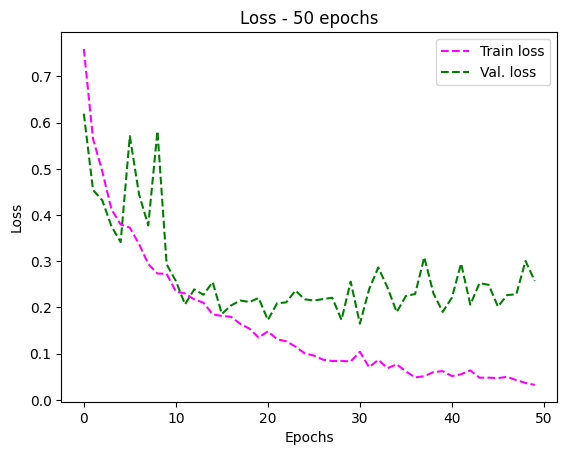

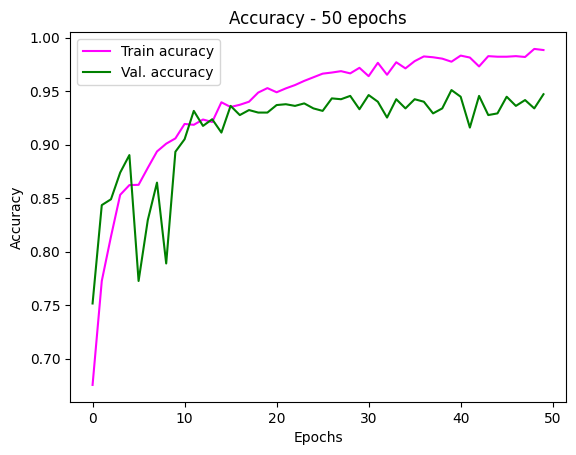

In [ ]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Titulo - Loss and accuracy chart
loss_title = 'Loss - ' + str(epochs) + ' epochs'
acc_title = 'Accuracy - ' + str(epochs) + ' epochs'

# Plot - Loss
plt.figure()
plt.title(loss_title)
plt.plot(epochs_list, train_loss_list, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green' ,ls='--', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('vgg_loss.pdf')

# Plot - Accuracy
plt.figure()
plt.title(acc_title)
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('vgg_acc.pdf')

## Evaluating the model
---

In [ ]:
# Lista com as classes reais e classes preditas
true_val_list = []
pred_val_list = []
# Lista com as probabilidades
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, labelList) in enumerate(val_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        labelList = labelList.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    ### _, preds = torch.max(output, 1)
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_val_batch = np.asarray(outputs_prob.cpu())

    # Classes reais true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_val_batch = np.asarray(labelList.cpu())
        pred_val_batch = np.asarray(preds.cpu())

    # Itera ao longo do lote
    for i in range(0, len(pred_val_batch)):
        true_val_list.append(true_val_batch[i])
        pred_val_list.append(pred_val_batch[i])

        prob_val_list.append(prob_val_batch[i])

## Confusion matrix and classification report
---

In [ ]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[639  12  10]
 [ 37 410  11]
 [  4   0 161]]

Class. report (validation)
                     precision    recall  f1-score   support

            Healthy     0.9397    0.9667    0.9530       661
Diabrotica speciosa     0.9716    0.8952    0.9318       458
        Caterpillar     0.8846    0.9758    0.9280       165

           accuracy                         0.9424      1284
          macro avg     0.9320    0.9459    0.9376      1284
       weighted avg     0.9440    0.9424    0.9422      1284



Validation Acc.: 0.9424
